In [1]:
import warnings
warnings.filterwarnings('ignore')
    
import arviz as az
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
from gala.units import UnitSystem
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pymc3 as pm
import pymc3_ext as pmx
from tqdm.notebook import tqdm
import astropy.table as at
from aesara_theano_fallback import tensor as tt
import exoplanet.units as xu
import json
import corner
import pandas as pd

from yellowcard.model_pymc3 import TimingArgumentModelPymc3

In [2]:
plt.rcParams.update({"text.usetex":False,"font.size":16})

palette = {"Dark":"#044751","Hydro": "#B6DAFF", 
           "All Pairs":"#668AFF", "Major Pairs": "#7B55F3",
           "Minor Pairs":'#FFB201',"Minor Plus Pairs":"#FF6300",
           "Extra":"#DE2280","Stellar":"#0A68DD",
           "Halo":"#4B0094","Max Halo":"#FF6BB7"}

In [3]:
usys = UnitSystem(1e12*u.Msun, u.kpc, u.Gyr, u.radian)

____
# Calculate means - run this first

In [4]:
modelChoices = ["vdm2012","fiducial2021","Dataset3"]


## Mass vs. vtravel

In [44]:
# --------------------- #
# get those means bby!! #
# --------------------- #
vtravels = np.arange(0,105,5)
vtravels = np.concatenate( (np.arange(0,105,5), np.array([32])) )

means_vtravel = {}
stds_vtravel = {}

for mod in modelChoices:
    means_vtravel[mod]={}
    stds_vtravel[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    means_vtravel[mod]['vtravel'] = vtravels
    stds_vtravel[mod]['vtravel'] = vtravels
    
    for vs in vtravels:
        data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).mean()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        means_vtravel[mod][param] = np.array(arr)
        stds_vtravel[mod][param] = np.array(arr_stds)


## Mass error vs. pm error

In [45]:
# mass error as function of proper motion improvement
pm_errs = np.array([1,2,4,8,16])

means_pmimprov = {}
stds_pmimprov = {}

for mod in modelChoices:
    means_pmimprov[mod]={}
    stds_pmimprov[mod]={}
    Ms, rs, es, etas, alphas = [],[],[],[],[]
    Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds = [],[],[],[],[]
    means_pmimprov[mod]['pm_errs'] = pm_errs
    stds_pmimprov[mod]['pm_errs'] = pm_errs
    
    for improv in pm_errs:
        data = az.from_json(f"../pymc3-data/{mod}_pmimprov_{improv}.json")
        
        for param,arr,arr_stds in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
            arr.append(np.asarray((data.posterior[param]).mean()))
            arr_stds.append(np.asarray((data.posterior[param]).std()))
            
    for param,arr,arr_stds  in zip(["M","r","e","eta","alpha"],[Ms,rs,es,etas,alphas],[Ms_stds, rs_stds, es_stds, etas_stds, alphas_stds]):
        means_pmimprov[mod][param] = np.array(arr)
        stds_pmimprov[mod][param] = np.array(arr_stds)
                

___

___
# Plots

## corner plots for all variables

In [26]:
# universal color and style choices
colors = {"vdm2012":"#DE2280",
          "fiducial2021":'#FFB201',
          "Dataset3": "#7B55F3"}

In [27]:
incl = 32
dat = 'vdm2012'
data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")


In [28]:
data.posterior

<xarray.Dataset>
Dimensions:             (chain: 4, draw: 8000, m31_icrs_xyz_dim_0: 3)
Coordinates:
  * chain               (chain) int64 0 1 2 3
  * draw                (draw) int64 0 1 2 3 4 5 ... 7995 7996 7997 7998 7999
  * m31_icrs_xyz_dim_0  (m31_icrs_xyz_dim_0) int64 0 1 2
Data variables: (12/21)
    vtravel_mag         (chain, draw) float64 23.16 23.16 23.38 ... 31.65 31.65
    vtravel_lon         (chain, draw) float64 0.8723 0.8723 ... 1.205 1.205
    vtravel_lat         (chain, draw) float64 -0.7992 -0.7992 ... -0.888 -0.888
    r                   (chain, draw) float64 813.5 813.5 803.4 ... 771.8 771.8
    M                   (chain, draw) float64 5.631 5.631 5.456 ... 4.8 4.8
    eta                 (chain, draw) float64 -2.082 -2.082 ... -2.093 -2.093
    ...                  ...
    sun_m31_dist        (chain, draw) float64 809.5 809.5 799.4 ... 767.7 767.7
    m31_icrs_xyz        (chain, draw, m31_icrs_xyz_dim_0) float64 597.9 ... 5...
    alpha               (chain, draw) float64 2.511 2.511 2.391 ... 2.924 2.924
    model_pmra          (chain, draw) float64 0.1064 0.1064 ... 0.08736 0.08736
    model_pmdec         (chain, draw) float64 -0.1534 -0.1534 ... -0.1115
    model_rv            (chain, draw) float64 -309.0 -309.0 ... -307.8 -307.8
Attributes:
    created_at:                 2021-12-17T19:58:50.183602
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.9.3
    sampling_time:              136.46498370170593
    tuning_steps:               4000

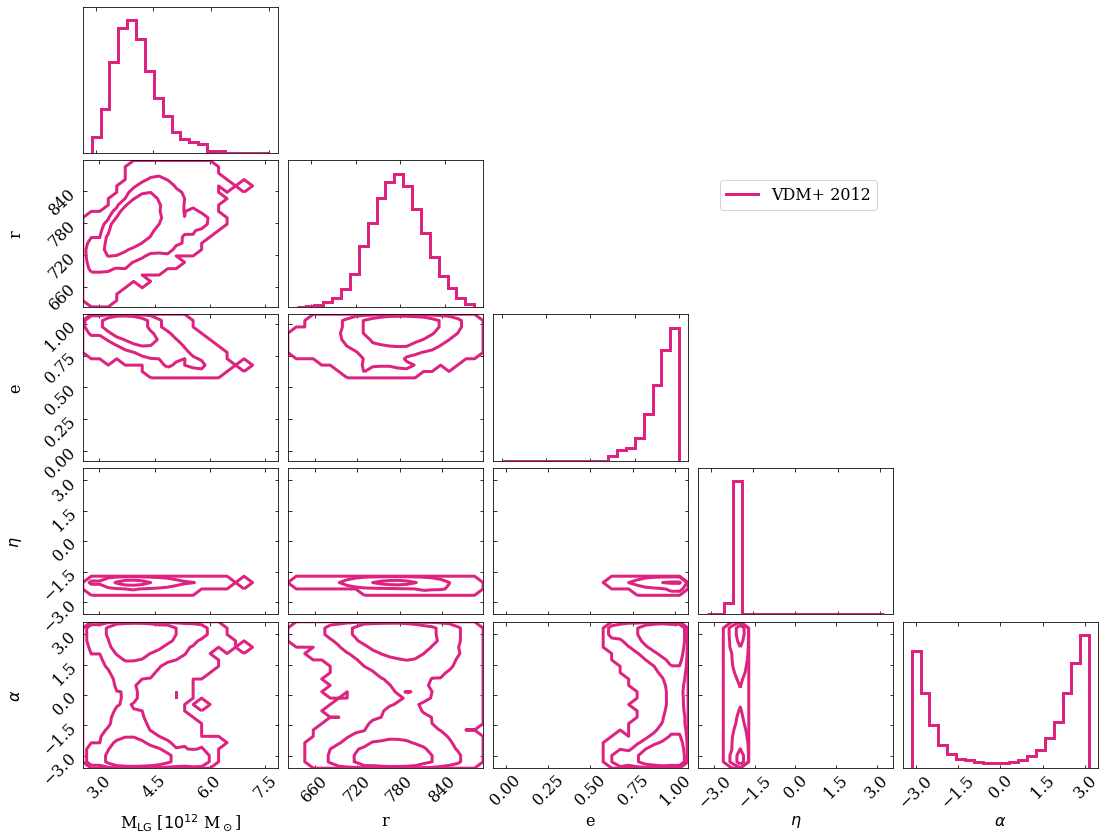

In [33]:
dataset = "vdm2012"
label = "VDM+ 2012"
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=colors[dataset],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=colors[dataset],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.png",dpi=300)
plt.show()





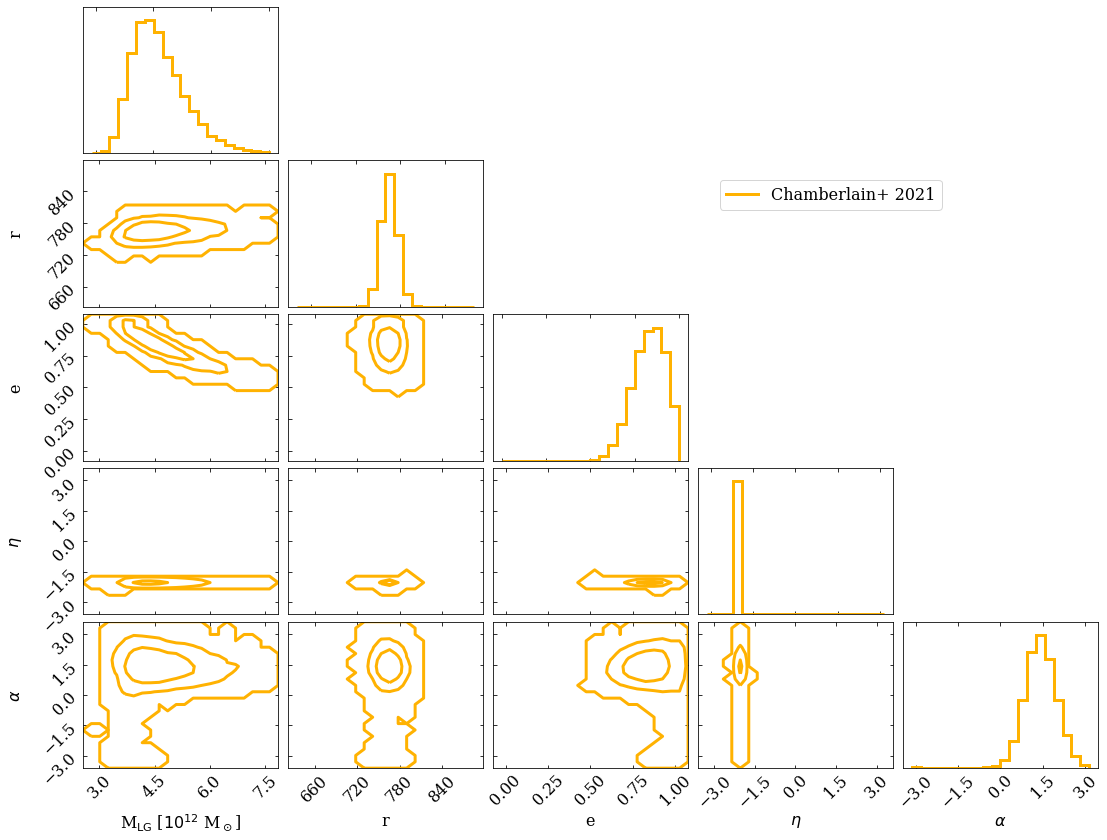

In [34]:
dataset = "fiducial2021"
label = "Chamberlain+ 2021"
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=colors[dataset],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=colors[dataset],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.png",dpi=300)
plt.show()





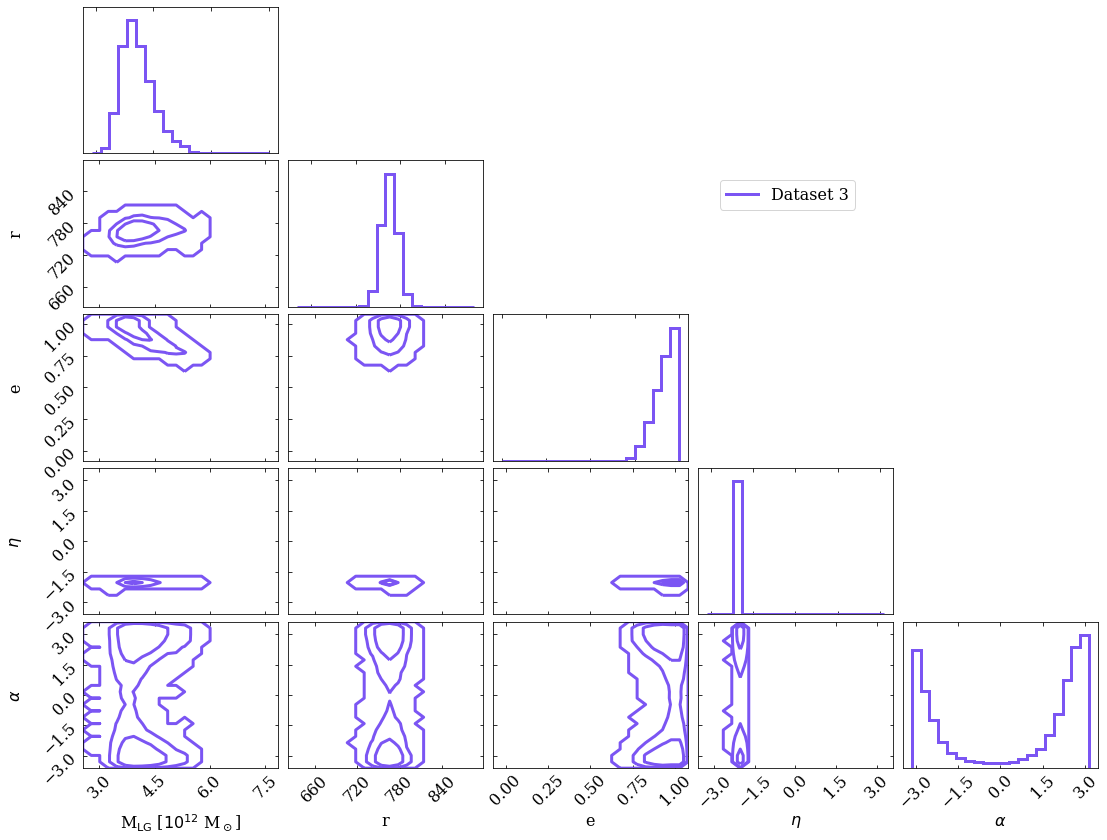

In [35]:
dataset = "Dataset3"
label = "Dataset 3"
vt = 32
fig = plt.figure(figsize=(16,12))

data = az.from_json(f"../pymc3-data/{dataset}_vtravel_{incl}.json")
howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e","eta","alpha"]])
corner.corner(howdy.T,
                labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r","e",r"$\eta$",r"$\alpha$"],
                plot_datapoints=False,
                plot_density=False,
                color=colors[dataset],
#                 linestyles=style[i],
                fig=fig,
                levels=[0.68, 0.95, 99.7],
                contour_kwargs={"linewidths":3},
                hist_kwargs={"linewidth":3},
                contourf_kwargs={"linestyles":3},
                range=[(2.9,7.5), (640,880), (0,1),(-np.pi,np.pi),(-np.pi,np.pi)]
             );
plt.plot(0,0,lw=3,color=colors[dataset],label=label)
fig.legend(loc=(0.65,0.75))
plt.savefig(f"../plots/analyze-runs-all-{dataset}.png",dpi=300)
plt.show()





## Model Comparison

32 vdm2012 Chamberlain+ 2021 solid is color #DE2280
32 fiducial2021 van der Marel+ 2012 solid is color #FFB201
32 Dataset3 3 solid is color #7B55F3


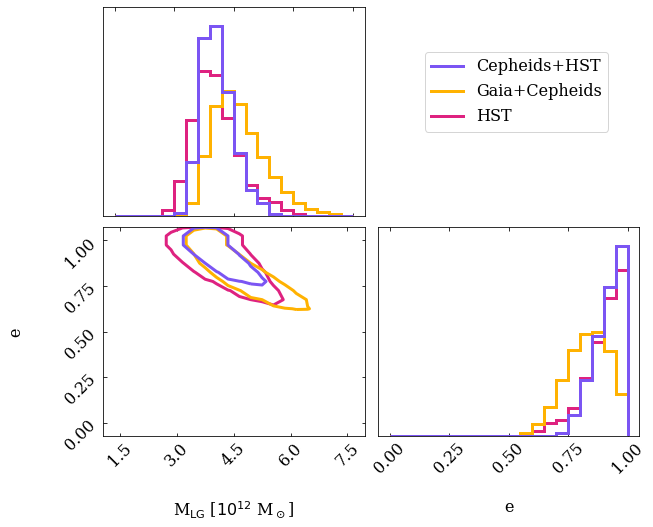

In [42]:
dataChoices = ["vdm2012","fiducial2021",'Dataset3']
label_model = ["Chamberlain+ 2021", "van der Marel+ 2012",'3']
include_vTravel = "32"
color = [palette['Extra'],palette['Minor Pairs'],palette['Major Pairs']]
# color = ["white","white","white","white"]
# color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
style = ['solid','solid','solid']
widths = [3,3,3]
model=[ "Our model","hey","sup"]


i=0
fig = plt.figure(figsize=(10,8))
for dat,name in zip(dataChoices,label_model):
    print(incl, dat, name,style[i], "is color", color[i])
    data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")
    howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])
    corner.corner(howdy.T,
                        labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
                        plot_datapoints=False,
                        plot_density=False,
                        color=color[i],
                        linestyles=style[i],
                        fig=fig,
                        levels=[ 0.95],
                        contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
                        hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
                        contourf_kwargs={"linestyles":style[i]},
                        range=[(1.5,7.5), (0,1)]
                 );
    i+=1
plt.plot(0,0,lw=3,color=palette["Major Pairs"],label=r"Cepheids+HST")
plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label="Gaia+Cepheids")
plt.plot(0,0,lw=3,color=palette["Extra"],label="HST")
fig.legend(loc=(0.65,0.75))
plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
plt.show()





0 vdm2012 Chamberlain+ 2021 dotted is color Grey
0 fiducial2021 van der Marel+ 2012 dotted is color Grey
0 Dataset3 3 dotted is color Grey
32 vdm2012 Chamberlain+ 2021 solid is color #DE2280
32 fiducial2021 van der Marel+ 2012 solid is color #FFB201
32 Dataset3 3 solid is color #7B55F3


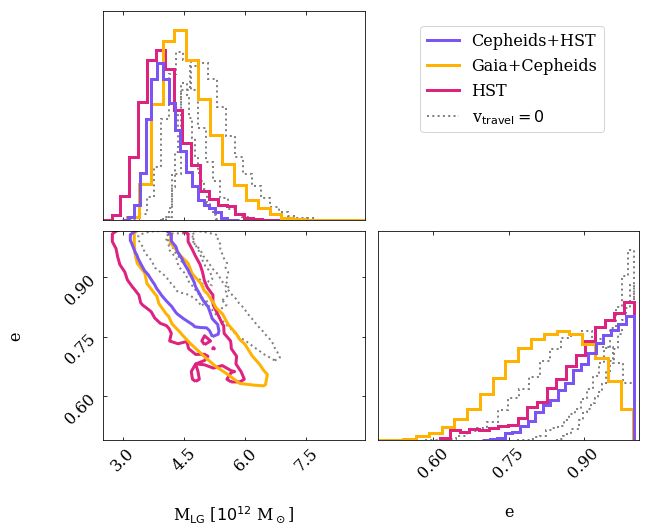

In [39]:
# # model comparison where v_t = 0 is in grey

# dataChoices = ["vdm2012","fiducial2021",'Dataset3']
# label_model = ["Chamberlain+ 2021", "van der Marel+ 2012",'3']
# include_vTravel = ["0","32"]
# color = ["Grey","Grey","Grey",palette['Extra'],palette['Minor Pairs'],palette['Major Pairs']]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['dotted','dotted','dotted','solid','solid','solid']
# widths = [2,2,2,3,3,3]
# model=[ "Old model","Old model","Our model", "Our model","hey","sup"]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for dat,name in zip(dataChoices,label_model):

#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, dat, name,style[i], "is color", color[i])
#         data = az.from_json(f"../pymc3-data/{dat}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","e"]])
#         corner.corner(howdy.T,
#                             labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","e"],
#                             plot_datapoints=False,
#                             plot_density=False,
#                             color=color[i],
#                             linestyles=style[i],
#                             fig=fig,
#                             levels=[ 0.95],
#                             contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                             hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                             contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Major Pairs"],label=r"Cepheids+HST")
# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label="Gaia+Cepheids")
# plt.plot(0,0,lw=3,color=palette["Extra"],label="HST")
# plt.plot(0,0,lw=2,color="gray",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
# fig.legend(loc=(0.65,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





In [43]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["Chamberlain+ 2021", "van der Marel+ 2012"]
# include_vTravel = ["0","32"]
# color = ["Grey","Grey",palette['Minor Pairs'],palette['Minor Pairs']]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','dotted','solid','dotted']
# widths = [2,2,3,3]
# model=[ "Old model","Old model","Our model", "Our model"]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):

#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i], "is color", color[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                             labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                             plot_datapoints=False,
#                             plot_density=False,
#                             color=color[i],
#                             linestyles=style[i],
#                             fig=fig,
#                             levels=[ 0.95],
#                             contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                             hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                             contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
        
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)

# plt.plot(0,0,lw=3,color=palette["Minor Pairs"],label=r"Chamberlain et. al 2021")
# plt.plot(0,0,lw=2,color="grey",linestyle="solid",label=r"v$_{\rm travel} = 0$")
# plt.plot(0,0,lw=3,color="gray",linestyle="solid",label="Dataset 1")
# plt.plot(0,0,lw=3,color="gray",linestyle="dashed",label="Dataset 2")
# fig.legend(loc=(0.55,0.75))
# # plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





32 vdm2012 van der Marel+ 2012 solid
32 fiducial2021 Chamberlain+ 2021 solid
0 vdm2012 van der Marel+ 2012 dotted
0 fiducial2021 Chamberlain+ 2021 dotted


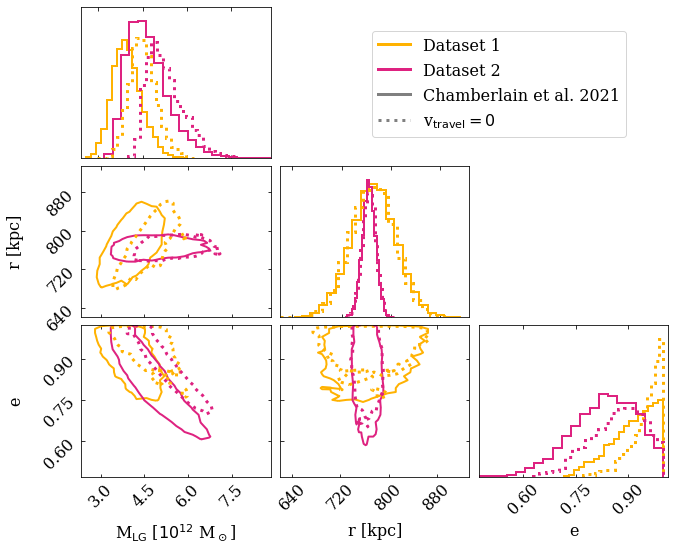

In [10]:
# modelChoices = ["vdm2012","fiducial2021"]
# label_model = ["van der Marel+ 2012","Chamberlain+ 2021"]
# include_vTravel = ["32","0"]
# color = [palette['Minor Pairs'],palette["Extra"],palette['Minor Pairs'],palette["Extra"]]
# # color = ["white","white","white","white"]
# # color = ["white","white",palette['Minor Pairs'],palette["Extra"]]
# style = ['solid','solid','dotted','dotted']
# widths = [2,2,3,3]


# i=0
# fig = plt.figure(figsize=(10,8))
# for incl in include_vTravel:
#     for mod,name in zip(modelChoices,label_model):
    
#         # uncomment if running for just dotted contours:
# #         if incl != "0":
# #             i+=1
# #             continue
#         print(incl, mod, name,style[i])
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{incl}.json")
#         howdy = np.vstack([np.asarray(data.posterior[i]).ravel() for i in ["M","r","e"]])
#         corner.corner(howdy.T,
#                         labels=[r"M$_{\rm LG}$ [$10^{12}$ M$_\odot$]","r [kpc]","e"],
#                         plot_datapoints=False,
#                         plot_density=False,
#                         color=color[i],
#                         linestyles=style[i],
#                         fig=fig,
#                         levels=[0.95],
#                         contour_kwargs={"linestyles":style[i],"linewidths":widths[i]},
#                         hist_kwargs={"linestyle":style[i],"linewidth":widths[i]},
#                         contourf_kwargs={"linestyles":style[i]},
# #                             range=[(2.9,7.5), (640,880), (0.56,1)]
#                      );
#         i+=1
# fig.savefig(f'../plots/analyze-runs-contour.png',dpi=300)
# plt.plot(0,0,lw=3,color=color[2],label="Dataset 1")
# plt.plot(0,0,lw=3,color=color[3],label="Dataset 2")
# plt.plot(0,0,lw=3,color="grey",label=r"Chamberlain et al. 2021")
# plt.plot(0,0,lw=3,color="grey",linestyle="dotted",label=r"v$_{\rm travel} = 0$")
# plt.arrow(0.5,0.5,-1,-0.5)
# fig.legend(loc=(0.55,0.75))
# plt.savefig("../plots/analyze-runs-contour.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_dotted.png",dpi=300)
# # plt.savefig("../plots/analyze-runs-contour_white.png",dpi=300)
# plt.show()





___
## Mass vs vtravel

In [55]:
means_vtravel["vdm2012"]["vtravel"][-1]

32

In [57]:
# distance of tracers in the halo vs. "measured" travel velocity from Garavito-Camargo 2021
nico_data = [[60.09584664536741, 45.45454545454547],
 [80.03194888178913, 70.27972027972028],
[100.22364217252397, 83.56643356643357],
[120.1597444089457, 92.65734265734265]] # note this is dist vs. velocity

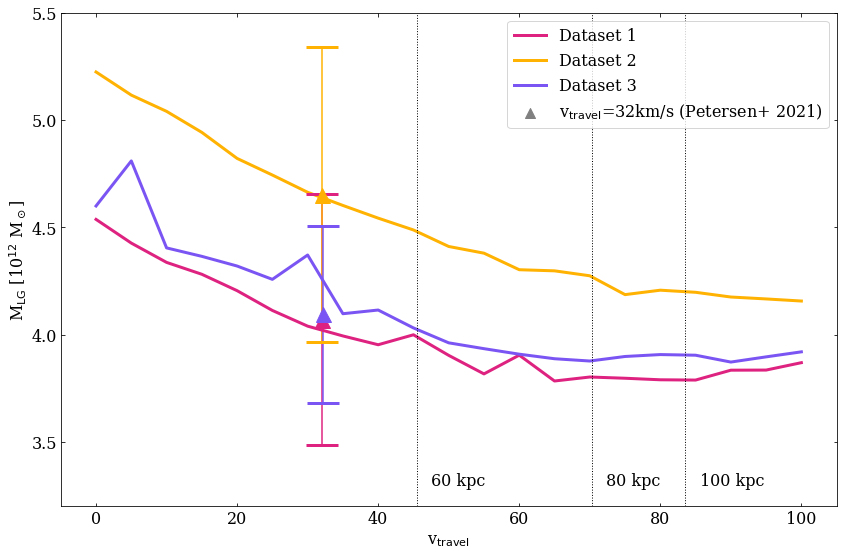

In [61]:
modelChoices = ["vdm2012","fiducial2021","Dataset3"]
label_model = ["vdM+ 2012 dataset","Chamberlain+ 2021 dataset","Dataset 3"]
label_model = ["Dataset 1","Dataset 2","Dataset 3"]

color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
alpha = [0,.1,0.2]

fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
    plt.plot(means_vtravel[mod]['vtravel'][:-1], means_vtravel[mod]['M'][:-1],
             label=lab, color=col, lw=3)

for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
    plt.errorbar(x=means_vtravel[mod]['vtravel'][-1]+al, 
                 y=means_vtravel[mod]['M'][-1],
                 yerr=stds_vtravel[mod]['M'][-1],
                 color=col,capsize=16,
                 capthick=3,marker='^',ms=15)

plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
ax.set_xlabel(r'v$_{\rm travel}$')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
for i in range(len(nico_data))[0:-1]:
    plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
    plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
plt.legend(loc="upper right")
plt.ylim(3.2,5.5)
plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvV.png",dpi=300)
plt.show()

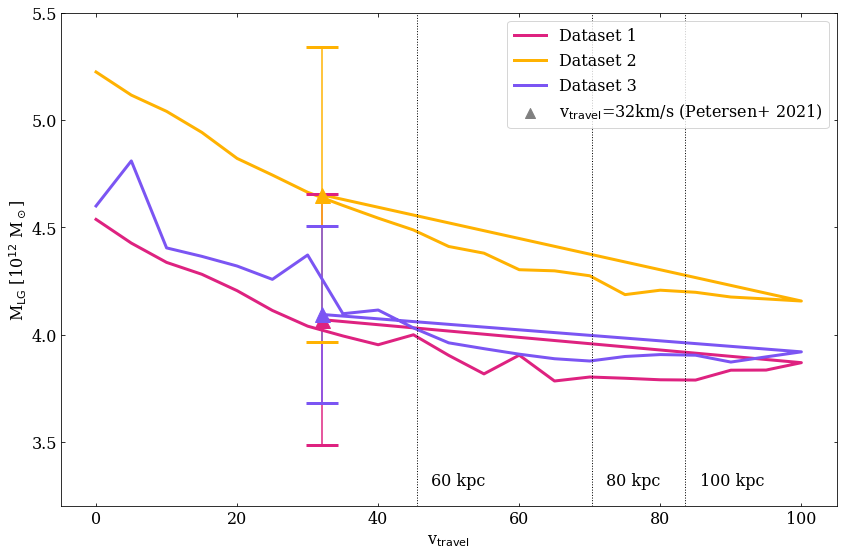

In [58]:
modelChoices = ["vdm2012","fiducial2021","Dataset3"]
label_model = ["vdM+ 2012 dataset","Chamberlain+ 2021 dataset","Dataset 3"]
label_model = ["Dataset 1","Dataset 2","Dataset 3"]
# label_model = ["Dataset 1","Dataset 2",""]


color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
alpha = [0,0,0]

fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
    bottoms = means_vtravel[mod]['M']-stds_vtravel[mod]['M']
    tops = means_vtravel[mod]['M']+stds_vtravel[mod]['M']
    
    plt.plot(means_vtravel[mod]['vtravel'], means_vtravel[mod]['M'],
             label=lab, color=col, lw=3)

for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
    plt.errorbar(x=means_vtravel_meas[mod]['vtravel'][1]+al, 
                 y=means_vtravel_meas[mod]['M'][1],
                 yerr=stds_vtravel_meas[mod]['M'][1],
                 color=col,capsize=16,
                 capthick=3,marker='^',ms=15)

plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
ax.set_xlabel(r'v$_{\rm travel}$')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
for i in range(len(nico_data))[0:-1]:
    plt.axvline(nico_data[i][1],color="black", linestyle="dotted", lw=1)
    plt.text(nico_data[i][1]+2, 3.3,"%.0f kpc" % nico_data[i][0])
plt.legend(loc="upper right")
plt.ylim(3.2,5.5)
plt.tight_layout()
plt.savefig("../plots/analyze-runs-MvV.png",dpi=300)
plt.show()

## All params vs. vtravel

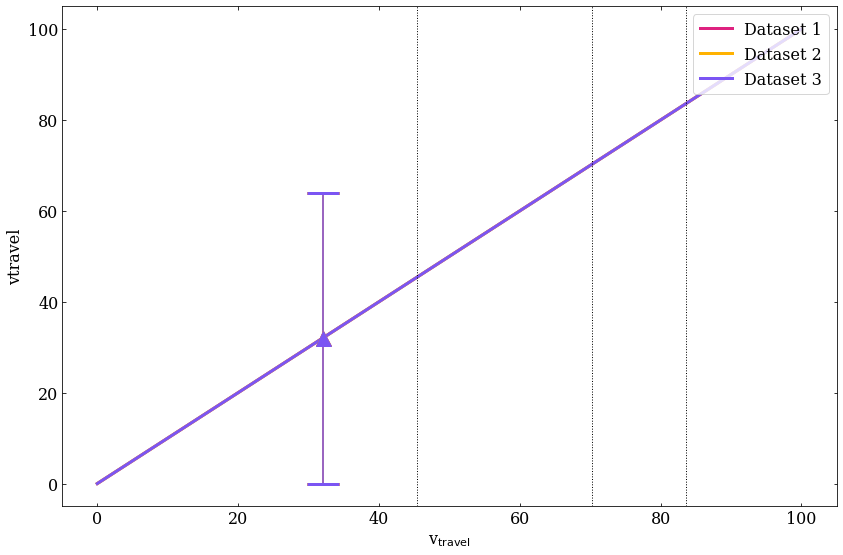

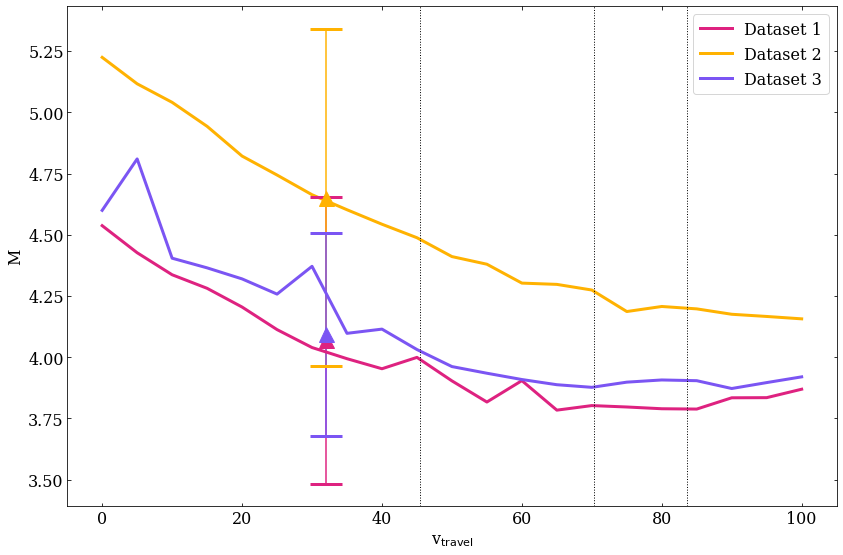

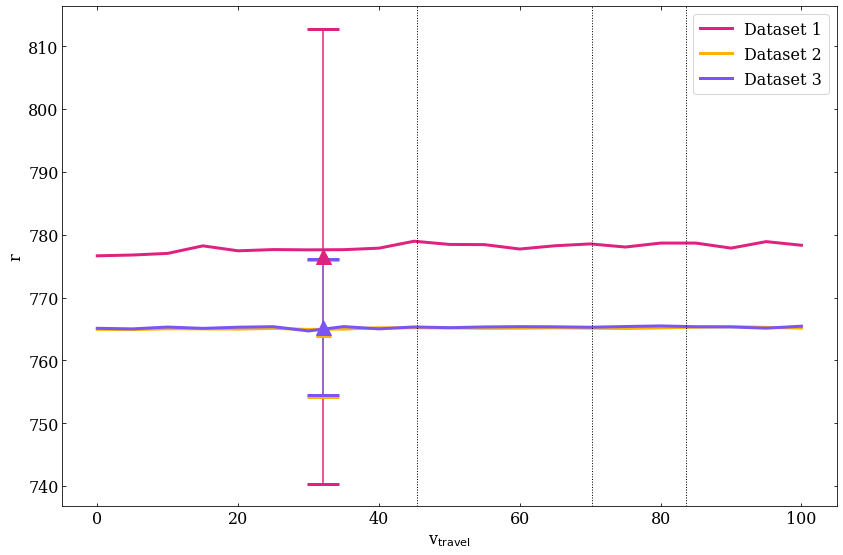

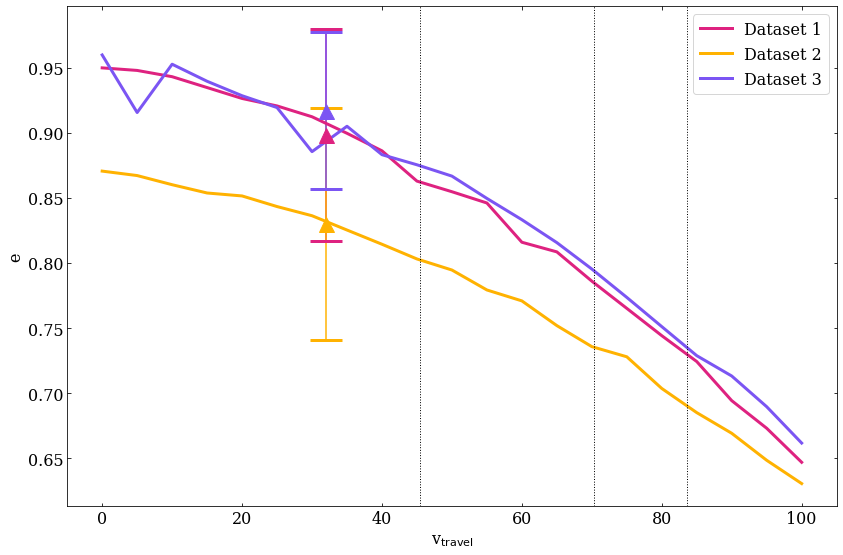

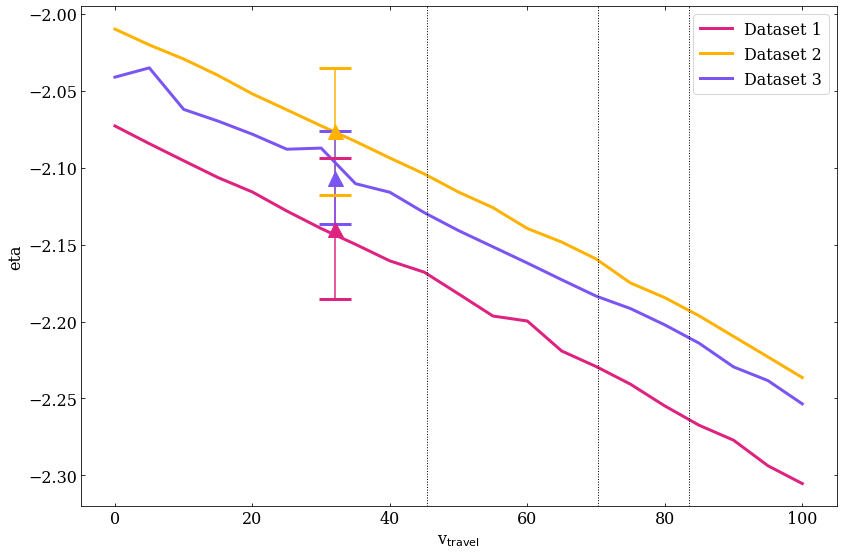

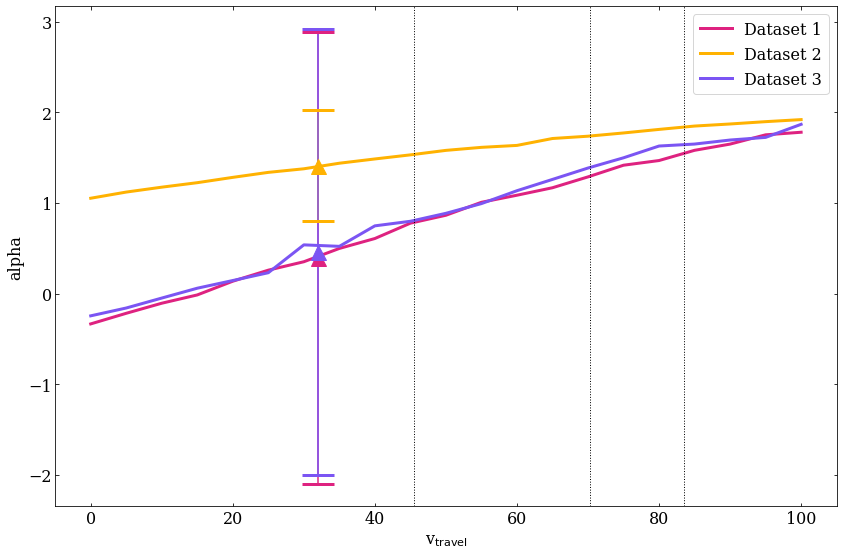

In [73]:
for i in means_vtravel['fiducial2021'].keys():
    
    modelChoices = ["vdm2012","fiducial2021","Dataset3"]
    label_model = ["vdM+ 2012 dataset","Chamberlain+ 2021 dataset","Dataset 3"]
    label_model = ["Dataset 1","Dataset 2","Dataset 3"]
    # label_model = ["Dataset 1","Dataset 2",""]


    color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
    alpha = [0,0,0]

    fig,ax=plt.subplots(figsize=(12,8))
    for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
        plt.plot(means_vtravel[mod]['vtravel'][:-1], means_vtravel[mod][i][:-1],
                 label=lab, color=col, lw=3)

    for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
        plt.errorbar(x=means_vtravel[mod]['vtravel'][-1]+al, 
                     y=means_vtravel[mod][i][-1],
                     yerr=stds_vtravel[mod][i][-1],
                     color=col,capsize=16,
                     capthick=3,marker='^',ms=15)

#     plt.scatter(0,0,label=r'v$_{\rm travel}$=32km/s (Petersen+ 2021)',marker="^",s=100,color='grey')
    ax.set_xlabel(r'v$_{\rm travel}$')
    ax.set_ylabel(f'{i}')
    for j in range(len(nico_data))[0:-1]:
        plt.axvline(nico_data[j][1],color="black", linestyle="dotted", lw=1)
#         plt.text(nico_data[j][1]+2, 3.3,"%.0f kpc" % nico_data[j][0])
    plt.legend(loc="upper right")
#     plt.ylim(3.2,5.5)
    plt.savefig(f"../plots/analyze-runs-{i}vsV.png")
    plt.tight_layout()
    plt.show()

___
## Mass constraint vs. pm error

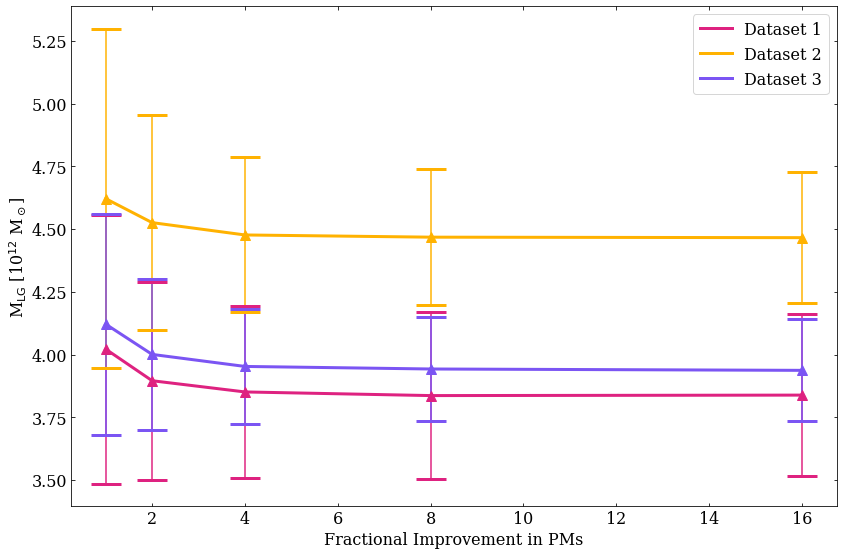

In [25]:
modelChoices = ["vdm2012","fiducial2021","Dataset3"]
label_model = ["Dataset 1","Dataset 2","Dataset 3"]


color = [palette["Extra"],palette['Minor Pairs'],palette['Major Pairs']]
# alpha = [0.2,0.4]

fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col in zip(modelChoices,label_model,color):
    
    plt.plot(means_pmimprov[mod]['pm_errs'], means_pmimprov[mod]['M'],
             label=lab, color=col, lw=3)

for mod,lab,col in zip(modelChoices,label_model,color):
    plt.errorbar(x=means_pmimprov[mod]['pm_errs'], 
                 y=means_pmimprov[mod]['M'],
                 yerr=stds_pmimprov[mod]['M'],
                 color=col, capsize=15,
                 capthick=3, marker='^',ms=10,
                 linestyle="")

# plt.scatter(0,0,label=r'v$_{\rm travel}$ from P21',marker="^",s=80,color='grey')
ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'M$_{\rm LG}$ [10$^{12}$ M$_\odot$]')
plt.legend()
# plt.ylim(3.2,5.5)
plt.tight_layout()
# plt.savefig("../plots/analyze-runs-MvsPM.png",dpi=300)
plt.show()

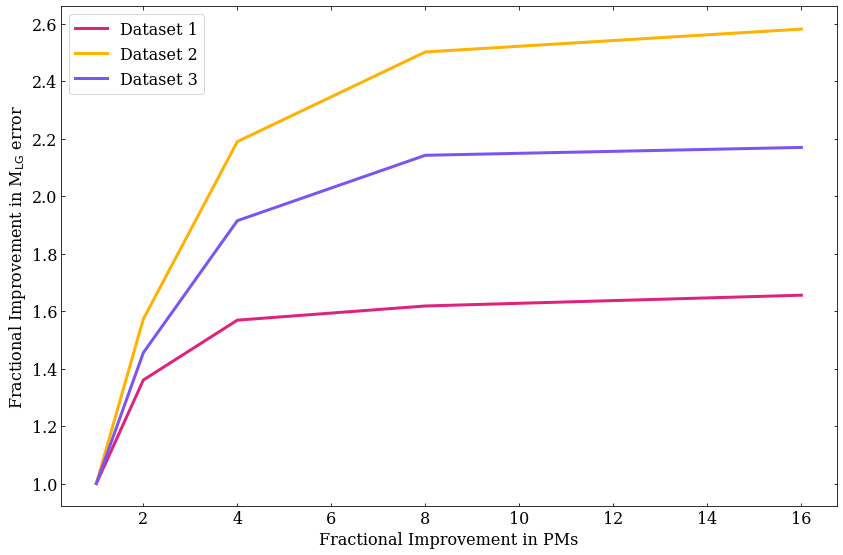

In [28]:
fig,ax=plt.subplots(figsize=(12,8))
for mod,lab,col in zip(modelChoices,label_model,color):
    
    plt.plot(means_pmimprov[mod]['pm_errs'], (stds_pmimprov[mod]['M']/stds_pmimprov[mod]['M'][0])**-1,
             label=lab, color=col, lw=3)

# for mod,lab,col,al in zip(modelChoices,label_model,color,alpha):
#     plt.errorbar(x=means_pmimprov[mod]['pm_errs'], 
#                  y=means_pmimprov[mod]['M'],
#                  yerr=stds_pmimprov[mod]['M'],
#                  color=col, capsize=15,
#                  capthick=3, marker='^',ms=10,
#                  linestyle="")

# plt.scatter(0,0,label=r'v$_{\rm travel}$ from P21',marker="^",s=80,color='grey')
ax.set_xlabel(r'Fractional Improvement in PMs')
ax.set_ylabel(r'Fractional Improvement in M$_{\rm LG}$ error')
plt.legend()
# plt.ylim(3.2,5.5)
plt.tight_layout()
plt.savefig("../plots/analyze-runs-deltaMvsPM.png",dpi=300)
plt.show()

In [41]:
stds_pmimprov['vdm2012']["pm_errs"]==10

array([False, False, False, False,  True, False, False, False, False])

In [43]:
stds_pmimprov['vdm2012']["M"][stds_pmimprov['vdm2012']["pm_errs"]==10]

array([1.39685868])

---

# Graveyard

## Measured vtravel

In [6]:
# vtravels_meas = np.array([0,32])
# means_vtravel_meas = {}
# stds_vtravel_meas = {}

# for mod in modelChoices:
#     means_vtravel_meas[mod]={}
#     stds_vtravel_meas[mod]={}
#     Ms, rs, es = [],[],[]
#     Ms_stds, rs_stds, es_stds = [],[],[]
#     means_vtravel_meas[mod]['vtravel'] = vtravels_meas
#     stds_vtravel_meas[mod]['vtravel'] = vtravels_meas
    
#     for vs in vtravels_meas:
#         data = az.from_json(f"../pymc3-data/{mod}_vtravel_{vs}.json")

#         for param,arr,arr_stds in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             arr.append(np.asarray((data.posterior[param]).mean()))
#             arr_stds.append(np.asarray((data.posterior[param]).std()))

#         for param,arr,arr_stds  in zip(["M","r","e"],[Ms,rs,es],[Ms_stds, rs_stds, es_stds]):
#             means_vtravel_meas[mod][param] = np.array(arr)
#             stds_vtravel_meas[mod][param] = np.array(arr_stds)

In [6]:
# means_vtravel_meas['fiducial2021']

In [7]:
# stds_vtravel_meas['fiducial2021']